In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report as cr, confusion_matrix as cm, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import lightgbm as lgb

In [86]:
# 1. Load dataset
df = pd.read_csv("../Fraud_dataset.csv")
df = df.apply(
    lambda col: col.str.lower() if col.dtype == "object" else col
)

colors = ['skyblue', 'orange']  # class 0 = skyblue, class 1 = orange


In [87]:
counts = df['fraud_bool'].value_counts()
majority = counts.max()
minority = counts.min()

imbalance_ratio = majority / minority
print("Majority class:", majority)
print("Minority class:", minority)
print("Imbalance Ratio (IR):", imbalance_ratio)

total = len(df)
minority_pct = (minority / total) * 100
print("Minority class percentage:", minority_pct)

Majority class: 988971
Minority class: 11029
Imbalance Ratio (IR): 89.67005168192946
Minority class percentage: 1.1029


In [88]:
# 2. Separate features and target
X = df.drop(columns=["fraud_bool"])
y = df["fraud_bool"]
print(X.head())
print(y.head())

   income  name_email_similarity  prev_address_months_count  \
0     0.3               0.986506                         -1   
1     0.8               0.617426                         -1   
2     0.8               0.996707                          9   
3     0.6               0.475100                         11   
4     0.9               0.842307                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            25            40            0.006735   
1                            89            20            0.010095   
2                            14            40            0.012316   
3                            14            30            0.006991   
4                            29            40            5.742626   

   intended_balcon_amount payment_type  zip_count_4w   velocity_6h  ...  \
0              102.453711           aa          1059  13096.035018  ...   
1               -0.849551           ad          1658   9

In [89]:
# 3. Identify categorical columns and convert them for SMOTENC
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
categorical_idx = [X.columns.get_loc(col) for col in categorical_cols]


In [90]:
# -------------------------------
# 4. TRUE HYBRID SAMPLING
# -------------------------------
# Partial undersampling of majority class
undersampler = RandomUnderSampler(
    sampling_strategy=0.15,   # majority becomes 2× minority
    random_state=42
)

# SMOTENC oversampling for categorical + numeric mixed data
smote_nc = SMOTENC(
    categorical_features=categorical_idx,
    random_state=42,
    sampling_strategy="auto"
)

# Pipeline applies UnderSampling → OverSampling
pipeline = Pipeline([
    ("under", undersampler),
    ("over", smote_nc)
])

X_resampled, y_resampled = pipeline.fit_resample(X, y)
print(X_resampled[0:3], y_resampled[0:3])

   income  name_email_similarity  prev_address_months_count  \
0     0.8               0.735925                        104   
1     0.9               0.313330                         -1   
2     0.1               0.129044                         -1   

   current_address_months_count  customer_age  days_since_request  \
0                            10            30            0.030076   
1                            30            30            0.002789   
2                           238            20            0.013602   

   intended_balcon_amount payment_type  zip_count_4w   velocity_6h  ...  \
0               -1.480613           ab          2062   1664.244920  ...   
1               -1.303670           ab          1498   7375.041588  ...   
2               -1.027149           ab          1019  11545.580597  ...   

   has_other_cards  proposed_credit_limit  foreign_request    source  \
0                0                  200.0                0  internet   
1                0       

In [91]:
# -------------------------------
# 7. BEFORE vs AFTER class counts
# -------------------------------
before_counts = y.value_counts()
after_counts = y_resampled.value_counts()

print("Before Hybrid Sampling:\n", before_counts)
print("\nAfter Hybrid Sampling:\n", after_counts)

# -------------------------------
# 8. CALCULATE sampling amounts
# -------------------------------
before_majority = before_counts.max()
before_minority = before_counts.min()

after_majority = after_counts.max()
after_minority = after_counts.min()

# How much undersampling?
undersampled_amount = before_majority - after_majority
undersampled_percent = (undersampled_amount / before_majority) * 100

# How much oversampling?
oversampled_amount = after_minority - before_minority
oversampled_percent = (oversampled_amount / before_minority) * 100

print("\n===== SAMPLING SUMMARY =====")
print(f"Majority BEFORE: {before_majority}")
print(f"Majority AFTER:  {after_majority}")
print(f"Undersampled amount: {undersampled_amount}")
print(f"Undersampled percent: {undersampled_percent:.2f}%\n")

print(f"Minority BEFORE: {before_minority}")
print(f"Minority AFTER:  {after_minority}")
print(f"Oversampled amount: {oversampled_amount}")
print(f"Oversampled percent: {oversampled_percent:.2f}%")


Before Hybrid Sampling:
 0    988971
1     11029
Name: fraud_bool, dtype: int64

After Hybrid Sampling:
 0    73526
1    73526
Name: fraud_bool, dtype: int64

===== SAMPLING SUMMARY =====
Majority BEFORE: 988971
Majority AFTER:  73526
Undersampled amount: 915445
Undersampled percent: 92.57%

Minority BEFORE: 11029
Minority AFTER:  73526
Oversampled amount: 62497
Oversampled percent: 566.66%


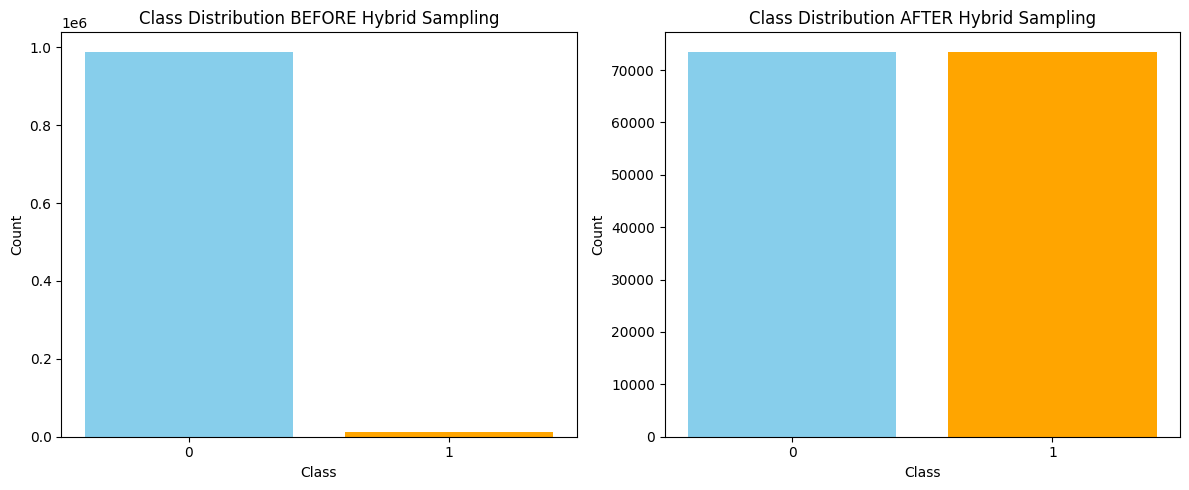

In [92]:
# -------------------------------
# 9. PLOT class distributions
# -------------------------------
plt.figure(figsize=(12, 5))
# Before sampling
plt.subplot(1, 2, 1)
plt.bar(before_counts.index.astype(str), before_counts.values, color=colors)
plt.title("Class Distribution BEFORE Hybrid Sampling")
plt.xlabel("Class")
plt.ylabel("Count")

# After sampling
plt.subplot(1, 2, 2)
plt.bar(after_counts.index.astype(str), after_counts.values, color=colors)
plt.title("Class Distribution AFTER Hybrid Sampling")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

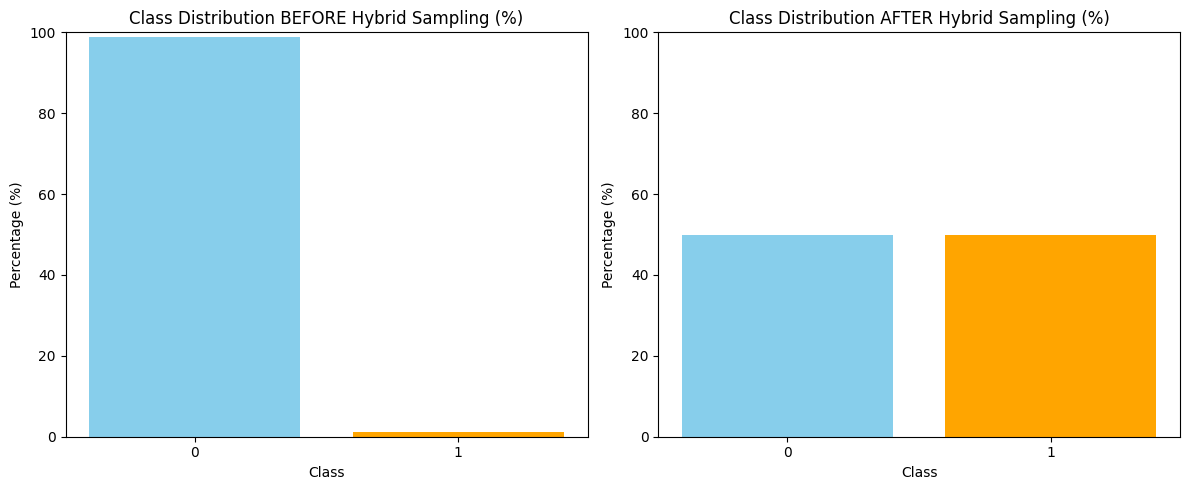

In [93]:

# -------------------------------
# 10. PLOT class distributions (percentages)
# -------------------------------
before_percent = before_counts / before_counts.sum() * 100
after_percent = after_counts / after_counts.sum() * 100

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(before_percent.index.astype(str), before_percent.values, color=colors)
plt.title("Class Distribution BEFORE Hybrid Sampling (%)")
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)

plt.subplot(1, 2, 2)
plt.bar(after_percent.index.astype(str), after_percent.values, color=colors)
plt.title("Class Distribution AFTER Hybrid Sampling (%)")
plt.xlabel("Class")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

In [94]:
# Combine features and target into a single DataFrame
df_resampled = X_resampled.copy()
df_resampled["fraud_bool"] = y_resampled.values

In [95]:
# Recalculate class counts to show sampling effect on the new "df_resampled"
before_counts = y.value_counts()
after_counts = df_resampled['fraud_bool'].value_counts()
print(f"Sampling applied. Total records AFTER resampling: {len(df_resampled)}")

Sampling applied. Total records AFTER resampling: 147052


In [96]:
# Missing Value Indicators (batch creation)
missing_df_resampled = pd.DataFrame({
    f"{col}_missing": df_resampled[col].isna().astype(int)
    for col in df_resampled.columns
    if df_resampled[col].isna().sum() > 0
})

missing_df_resampled.head()

""


In [97]:
# Checking for duplicates
df_resampled.duplicated().sum()

0

In [98]:
# Calculate Q1 and Q3 for numeric columns
Q1 = df_resampled.quantile(0.25)
Q3 = df_resampled.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers: True if value < Q1 - 1.5*IQR or > Q3 + 1.5*IQR
outliers = ((df_resampled < (Q1 - 1.5 * IQR)) | (df_resampled > (Q3 + 1.5 * IQR)))

# Count of outliers per column
outliers.sum()


C:\Users\Emma. O.Kyei Mckeow\AppData\Local\Temp\ipykernel_16388\316994301.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df_resampled.quantile(0.25)
C:\Users\Emma. O.Kyei Mckeow\AppData\Local\Temp\ipykernel_16388\316994301.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df_resampled.quantile(0.75)
C:\Users\Emma. O.Kyei Mckeow\AppData\Local\Temp\ipykernel_16388\316994301.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers = ((df_resampled < (

bank_branch_count_8w                23400
bank_months_count                       0
credit_risk_score                     172
current_address_months_count         4885
customer_age                          400
date_of_birth_distinct_emails_4w     2458
days_since_request                  21024
device_distinct_emails_8w            5849
device_fraud_count                      0
device_os                               0
email_is_free                           0
employment_status                       0
foreign_request                      2526
fraud_bool                              0
has_other_cards                     17892
housing_status                          0
income                                  0
intended_balcon_amount              31951
keep_alive_session                      0
month                                   0
name_email_similarity                   0
payment_type                            0
phone_home_valid                        0
phone_mobile_valid                

In [99]:
# Outlier Capping (using thresholds from the resampled data)
df_cleaned = df_resampled.copy()
cap_cols = [
    'prev_address_months_count', 'current_address_months_count', 'customer_age',
    'days_since_request', 'intended_balcon_amount', 'zip_count_4w',
    'velocity_6h', 'velocity_24h', 'bank_branch_count_8w',
    'date_of_birth_distinct_emails_4w', 'employment_status',
    'credit_risk_score', 'phone_mobile_valid', 'has_other_cards',
    'foreign_request', 'session_length_in_minutes', 'device_distinct_emails_8w'
]
numeric_cols = df_cleaned.select_dtypes(include=np.number).columns
cap_cols_numeric = [col for col in cap_cols if col in numeric_cols]

for col in cap_cols_numeric:
    lower = df_cleaned[col].quantile(0.01)
    upper = df_cleaned[col].quantile(0.99)
    df_cleaned[col] = df_cleaned[col].clip(lower, upper)

In [100]:
# Log Transformation
skewed_cols = [
    col for col in df_cleaned.columns
    if df_cleaned[col].dtype != 'O'
    and df_cleaned[col].nunique() > 10
    and (df_cleaned[col] > 0).all()
]
log_df = pd.DataFrame({
    f"{col}_log": np.log1p(df_cleaned[col])
    for col in skewed_cols
})

In [101]:
# Interaction Features
interaction_pairs = [
    ("velocity_6h", "velocity_24h"),
    ("device_fraud_count", "device_distinct_emails_8w"),
    ("prev_address_months_count", "current_address_months_count"),
]
interaction_dict = {}

for f1, f2 in interaction_pairs:
    if f1 in df_cleaned.columns and f2 in df_cleaned.columns:
        interaction_dict[f"{f1}_x_{f2}"]    = df_cleaned[f1] * df_cleaned[f2]
        interaction_dict[f"{f1}_plus_{f2}"] = df_cleaned[f1] + df_cleaned[f2]
        interaction_dict[f"{f1}_ratio_{f2}"] = df_cleaned[f1] / (df_cleaned[f2] + 1) # Added +1 to denominator to avoid division by zero which sometimes happens when SMOTE generates values outside of original range 

interaction_df = pd.DataFrame(interaction_dict)
df_engineered = pd.concat([df_cleaned, missing_df_resampled, log_df, interaction_df], axis=1)

In [102]:
# ----------------------------------------------------
# 6. SPLIT INTO TRAIN, VAL, TEST (ON PROCESSED DATA)
# ----------------------------------------------------

X = df_engineered.drop(columns=["fraud_bool"])
y = df_engineered["fraud_bool"]

# Convert categorical columns to numeric category codes for LGBM (final preprocessing step before split)
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
for col in categorical_cols:
    X[col] = X[col].astype("category").cat.codes

# 70-15-15 split (stratified is not strictly necessary anymore but kept for consistency with original approach)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [103]:
# Separate object columns in X_train for final categorical encoding (although done on X already, this re-ensures it's right)
categorical_cols_lgbm = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
for col in categorical_cols_lgbm:
    X_train[col] = X_train[col].astype("category").cat.codes
    X_test[col] = X_test[col].astype("category").cat.codes
    X_val[col] = X_val[col].astype("category").cat.codes

# Ensure X_val and X_test have the exact same columns as X_train (for modeling)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

In [104]:
# ----------------------------------------------------
# 7. MODEL TRAINING AND EVALUATION (Rest of the procedure)
# ----------------------------------------------------

# Model Definition
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

# Model Training
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)], # Use X_val here as X_val_encoded is no longer created
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=200),
        log_evaluation(period=100)
    ]
)

[LightGBM] [Info] Number of positive: 51468, number of negative: 51468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8098
[LightGBM] [Info] Number of data points in the train set: 102936, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.978782	valid_0's binary_logloss: 0.187548
[200]	valid_0's auc: 0.982251	valid_0's binary_logloss: 0.161295
[300]	valid_0's auc: 0.982946	valid_0's binary_logloss: 0.15612
[400]	valid_0's auc: 0.983261	valid_0's binary_logloss: 0.153918
[500]	valid_0's auc: 0.983438	valid_0's binary_logloss: 0.152582
Did not meet early stopping. Best iteration is:
[500]	valid_0's auc: 0.983438	valid_0's binary_logloss: 0.152582


LGBMClassifier(colsample_bytree=0.9, learning_rate=0.05, n_estimators=500,
               random_state=42, subsample=0.9)

In [105]:
y_pred = lgb_model.predict(X_test)
y_prob = lgb_model.predict_proba(X_test)[:, 1]

In [106]:
# Threshold Optimization (on Validation set to find best_threshold)
y_val_prob = lgb_model.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.01, 1.0, 0.01)
best_threshold = 0.5
best_f1 = 0

for t in thresholds:
    y_pred_val = (y_val_prob >= t).astype(int)
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)

    # Only consider thresholds meeting both precision and recall criteria
    if precision >= 0.25 and recall >= 0.5 and f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print("Best Threshold:", best_threshold)
print("Best F1 Score:", best_f1)


Best Threshold: 0.47000000000000003
Best F1 Score: 0.9403334711313215



=== LIGHTGBM CLASSIFICATION REPORT (Threshold = 0.47) ===
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     11029
           1       0.95      0.93      0.94     11029

    accuracy                           0.94     22058
   macro avg       0.94      0.94      0.94     22058
weighted avg       0.94      0.94      0.94     22058



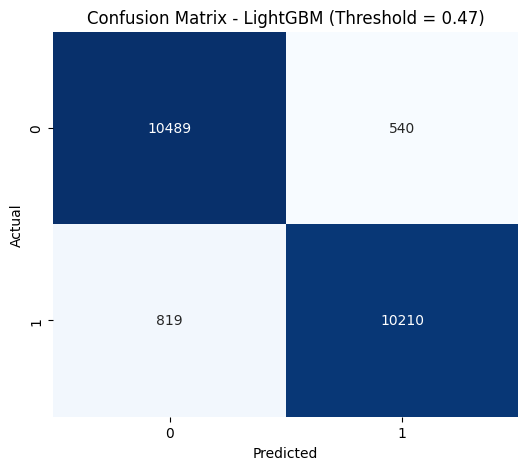


=== ROC-AUC SCORE ===
0.9841

Precision: 0.950, Recall: 0.926, F1: 0.938


In [107]:
# 3. Apply threshold
threshold = 0.47
y_pred_final = (y_prob >= threshold).astype(int)

# 4. Classification report
print(f"\n=== LIGHTGBM CLASSIFICATION REPORT (Threshold = {threshold}) ===")
print(cr(y_test, y_pred_final))

# 5. Confusion matrix
cmatrix = cm(y_test, y_pred_final)
plt.figure(figsize=(6,5))
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix - LightGBM (Threshold = {threshold})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 6. ROC-AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\n=== ROC-AUC SCORE ===\n{roc_auc:.4f}")

# Optional: Precision, Recall, F1 at this threshold
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
